# Homewor 4 - Applied Machine Learning

In this notebook we will present our solution for the 4<sup>th</sup> homework of ADA.

We begin by importing the important librairies.

In [2]:
import pandas as pd                                    
import numpy as np 
import myFunction # the function has been defined by us. See myFunction.py
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline




Populating the interactive namespace from numpy and matplotlib


The first step we do is importing the data and taking a look at it.

In [3]:
data = pd.read_csv('Data/CrowdstormingDataJuly1st.csv')
data.ix[:5,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0


In [4]:
data.ix[:5,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


#### Data Cleaning

We will start by cleaning the data in several steps. The first computation we do is extracting the rater information. As we saw, the raters disagree often. We decide not to discard values where the raters disagree, but to average the rating given by the two raters. But this does not take into account the Nana values in the rating so it's a complete description of the disagreement.

In [5]:
print('Number of cases where the two raters agree :',
      (data.rater1 == data.rater2).sum()/len(data)*100, ' %')

Number of cases where the two raters agree : 65.5449639795  %


Now we will compute the new column for the average rating.

In [6]:
data_clean0 = data.copy()
data_clean0['meanRating'] = (data.rater1.values + data.rater2.values)/2

As shown in a previous analysis from this [notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) it was shown that there is a problem regarding data coming from other leagues than the four of interest. For each player there are his games during his entire career, not only the games in the four leagues where the data comes from.

To keep only the main games, we keep referee-dyad players that are present more than 22 times (if a referee officiated 1 matches in a league, he will be present 22 times or more, as there are 22 players in a match).

As we plan to aggregate the data per player, we find that our data will be skewed if we include matches coming from other countries, we will therefore remove them.

In [7]:
refs = data_clean0.refNum.value_counts()

#We pick only the lines where the referee was more than 22 times.
goodRefs = refs[refs>21]

data_clean0 = data_clean0[data_clean0.refNum.isin(goodRefs.index.values)] 

Then, we remove columns that are not relevant (They are not part of the player description or will not be usefull for classification) for the training data and also remove each row where there is no ratings, which means rows where there is no photo ID available, which also means that there is not rater information. These rows are not useful for classification.

We remove these columns:
- photoID
- rater1
- rater2
- playerShort
- birthday
- refNum
- refCountrs 

In [8]:
data_clean1 = data_clean0.dropna(subset=['photoID'])
data_clean2 = data_clean1.drop(['photoID', 'rater1',
                                'rater2', 'playerShort', 'birthday',
                                'refNum', 'refCountry' ],1)

We will also deal with data types. First we take a look at the type of each column.

In [9]:
data_clean2.dtypes

player            object
club              object
leagueCountry     object
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
meanRating       float64
dtype: object

As we can see, a lot of these columns are of object type. This is a problem because learning algorithms are unable to deal with categorical data. We designed a way to deal with this problem and will show our processing pipeline below.

We begin by changing the null value present in the datatypes below to Unknown

In [10]:
data_clean2.position.fillna("Unknown",inplace=True)
data_clean2.Alpha_3.fillna("Unknown",inplace=True)

We then cast the data types to string to enable using label encoder

In [11]:
data_clean2['position'] = data_clean2['position'].astype('str') 
data_clean2['Alpha_3'] = data_clean2['Alpha_3'].astype('str') 

Then we encode the rest of data sest that are not numerical using the function myfunction that is provided in the main folder.

The encoding basically gives each categorical value in the affected column(column with data type object) a unique identification number. This number is a reference to the object value it represent in the affected column. In this part of the of the homework, we provide provided step by step guide on how to do this. For Example "Attacking MidFielder" in the position column can be encoded as 1.

Below we collect all columns of object datatype from our data set below in CrowdstormingDataJuly1st_object_columns. The aim of this is be able to encode such columns at once. Sklearn as yet does not provide such functionality.

In [12]:
data_object = data_clean2.iloc[:, :].select_dtypes(include=['object']).columns

We defined  myFunction.MultiColumnLabelEncoder which  effectively Wraps sklearn LabelEncoder functionality(for encoding categorical variables) for use on multiple columns  of our data set. The multiple columns are those which were extracted above. As can be observed we parsed all such columns into myFunction.MultiColumnLabelEncoder.

In [13]:
#create an instance of MultiColumnLabelEncoder and Pass the columns extracted to it
ColumnObjectEncoder = myFunction.MultiColumnLabelEncoder(columns=data_object)

 The fit method of myFunction.MultiColumnLabelEncoder accesses individual column of our dataset via indexing. This effectively returns the columns of our data set which are of type object.

In [14]:
ColumnObjectEncoder.fit(data_clean2)

MultiColumnLabelEncoder(columns=Index(['player', 'club', 'leagueCountry', 'position', 'Alpha_3'], dtype='object'))

We transform the columns of  object data type to encoded labels. This we do by calling ColumnObjectEncoder.transform.

In [15]:
# Finally transform 
ColumnObjectEncoder.transform(data_clean2)

array([[ 392,   34,    0,    1,   53],
       [ 425,   48,    0,    6,   53],
       [ 440,   54,    0,    4,   53],
       ..., 
       [1536,   12,    2,    7,   42],
       [1541,   91,    0,    8,   42],
       [1553,    1,    2,    9,   42]])

Now we can see that all our columns are numerical value and can be used by the RandomForest classifier

In [16]:
data_clean2.ix[:,:11].head()

,player,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals
5,392,34,0,182.0,71.0,1,1,0,0,1,0
6,425,48,0,187.0,80.0,6,1,1,0,0,0
7,440,54,0,180.0,68.0,4,1,0,0,1,0
8,454,49,0,193.0,80.0,5,1,0,1,0,0
9,456,2,2,180.0,70.0,9,1,1,0,0,0


In [17]:
data_clean2.ix[:,11:22].head()

,yellowCards,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanRating
5,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
8,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
9,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000


We then look at the data and we find that there are still a few nan values that are present in the data. But as we see there are not a lot. We decide to let go of them.

In [18]:
data_clean2.isnull().sum()

player             0
club               0
leagueCountry      0
height            23
weight           625
position           0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
Alpha_3            0
meanIAT          110
nIAT             110
seIAT            110
meanExp          110
nExp             110
seExp            110
meanRating         0
dtype: int64

In [19]:
data_clean2 = data_clean2.dropna()

As we see we have dropped a large set of data, we will check that we did not loose too much data. We see that we only dropped 15% of the data which is quite good.

In [20]:
print('Percentage of data that was kept :',len(data_clean2)/len(data)*100,' %')

Percentage of data that was kept : 77.4693894321637  %


#### Player Aggregation

Now that we have cleaned the data we will aggregate the data per player. We will start by grouping by players and taking a look at one player

In [21]:
players = data_clean2.groupby('player')
players.get_group(34).ix[:,0:12].head()

,player,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards
2401,34,69,3,177.0,70.0,6,4,0,2,2,0,1
3190,34,69,3,177.0,70.0,6,8,4,2,2,0,0
5475,34,69,3,177.0,70.0,6,7,2,2,3,0,0
5905,34,69,3,177.0,70.0,6,2,1,0,1,0,0
6188,34,69,3,177.0,70.0,6,3,1,2,0,0,2


In [22]:
players.get_group(3).ix[:,12:22].head()

,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanRating
2316,1,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
3141,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
4013,0,0,76,0.398174,526.0,0.000809,1.212727,550.0,0.004521,0.25
5426,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
5874,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25


As we can see, we have to apply different functions that have to be applied for each column for a correct aggregation without loosing any information.

For different columns we will apply different functions:
- club, leagueCountry, height, age, position, Alpha_3, meanRating : Taking the most frequent value in all games is a good representation of the player. (For height, age and meanRating it will be the right value).
- games, victories, ties, defeats, goals, yellowCards, yellowReds, redCards we will sum all the values. 
- For the referee information we will use a custom functions

#### Aggregating referee information

Let's take a custom player represented by the following table, a set of referee - player dyad.

| meanIAT | nIAT | seIAT |
|---------|------|-------|
| $$m_1$$      | $$N_1$$   | $$s_1$$    |
|    $$m_2$$   | $$N_2$$   | $$s_2$$    |
| $$m_3$$      | $$N_3$$   | $$s_3$$    |

Given this information we need to calculate the new values per player that ecompasses the information from all of the dyads for one player.

For the mean we choose the following function:


$$MeanIATPlayer = \frac{m_1*N_1 + m_2*N_2 + m_3*N_3}{N_1+N_2+N_3}$$

The new number of samples is simply:

$$N_{tot} = N_1+N_2+N_33$$

And finally the standard deviation is simply computed with the data above:

$$STD = \sqrt{\frac{1}{N_{tot}}*\sum_{i}^{n}(m_i - meanIATPlayer)^2)}$$


The aggregation is done in the notebook "Aggregation".

# Prediction of the skin color

Now that we have the data we will begin with the machine learning part.


For this dataset we decided to treat the problem as binary, meaning the player can be either black or white (1.0 or 0.0). To do this we need to divide the skin colors in two categories. We change the value smaller or equal to 0.5 to 0.0 and the other values to 1.0. This is done by the function defined below.

In [23]:
#Use the mean of the two raters as the target output (removing the nan, where the photo is not available)
playerData = pd.read_csv('Data/playerData.csv')

data_features = playerData.drop(['meanRating','Unnamed: 0'], axis=1)


#We will define the function to transform the ratings into binary classes

def transform_rating(series):
    if series <= 0.5:
        return 0.0
    else:
        return 1.0

# We collect the labels from the data 
labels = playerData['meanRating'].apply(transform_rating)
labels.shape

(1551,)

Quick look of the data

In [24]:
data_features.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,yellowRed
0,29,3,172.0,67.0,7,364,226,57,81,32,...,1,3,30,0.330002,2574735.0,0.000231,0.330002,2655936.0,0.001431,1.0
1,10,3,183.0,73.0,2,294,145,62,87,60,...,0,0,30,0.329110,2565503.0,0.000233,0.329110,2647455.0,0.001179,0.0
2,35,3,171.0,69.0,2,178,53,43,82,39,...,1,0,30,0.366673,87911.0,0.000358,0.366673,92973.0,0.001335,1.0
3,9,3,182.0,78.0,2,322,125,82,115,105,...,3,4,30,0.340878,305901.0,0.000437,0.340878,321422.0,0.002612,3.0
4,66,3,190.0,88.0,5,44,22,6,16,0,...,0,1,30,0.348044,105304.0,0.000459,0.348044,110781.0,0.002894,0.0


We will apply a Random Forest classifier on our data in order to predict the skin color of a players based on its description data

Here we importe the sklearn function we need and train the classifier on all the data set. We predict the training accuracy

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Training accuracy of the random forest classifier on all data

randomforest = RandomForestClassifier()

randomforest.fit(data_features,labels)

data_predict = randomforest.predict(data_features)

# compute classification accuracy for the Random forest classifier model

print(metrics.accuracy_score(labels, data_predict))

0.975499677627


We see that we obtain a high accurary. But this is only training accuracy obtained by testing our model on the same data used to train it and it doesn't reliably represent the accuracy of the model. For that, we need testing accuracy by testing the model on data that were not used for training. This is what is done below



We start by splitting the data in testing and training sets

In [26]:
#split data_features and data_labels into training and testing sets
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train,labels_test = train_test_split(data_features,labels, test_size=0.4, random_state=4)

/Users/thomasvetterli/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here we predict the labels for both the training and testing sets

In [27]:
randomforest = RandomForestClassifier()
randomforest.fit(features_train, labels_train)
labels_pred_test = randomforest.predict(features_test) #testing prediction
labels_pred_train = randomforest.predict(features_train) #training prediction

#training accuracy
print('training accuracy')
print(metrics.accuracy_score(labels_train, labels_pred_train))
#testing accuracy
print('testing accuracy')
print(metrics.accuracy_score(labels_test, labels_pred_test))

training accuracy
0.981720430108
testing accuracy
0.80998389694


We can see that the testing accuracy is smaller than the training accuracy as expected. 

We can show the result with more precision in another form using a confusion matrix. 

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(labels_test, labels_pred_test)
confusion_matrix

array([[491,  22],
       [ 96,  12]])

We can see that we classify white player pretty well. We have a large fraction correctly classified white player (up right) and a small fraction white player that are classified as black (low right). The classification for the black player is less accurate. A little more black players are correctly classified (low left) against black player misclassified (up left). A rate that is close to 50-50 which is not particularly good. The fact that there is more white player should play an important role in this result.

# Effect of parameters over overfitting

Now we will investigate the effect of some parameters on the model. Particularly, we will see if certain value lead to overfitting

To show the impact of the parameters of the RandomForestClassifier over the overfitting issue we will plot the training and testing accuracy againt different value for tested parameters. We will not use crossvalidation as before as it return the testing accuracy and not the training accuracy. Instead the data set will simply be split into training data and testing data (40% for testing data).



In [29]:
#split data_features and data_labels into training and testing sets
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(data_features, labels, test_size=0.4, random_state=4)


Here we will the see the impact of the parameter 'min_samples_split' which represent the minimum number of samples required to split an internal node. This means that a a bigger number will simplify the model and that the value 2 (the minimum possible) represent the maximum complexity relatively to this parameter.

In [30]:
#Hyperparameter 'min_samples_split'

split_range = list(range(2,16))
scores_test = []
scores_train = []
for number in split_range:
    randomforest = RandomForestClassifier(min_samples_split=number)
    randomforest.fit(features_train, labels_train)
    labels_pred_test = randomforest.predict(features_test) #testing prediction
    labels_pred_train = randomforest.predict(features_train) #training prediction
    
    scores_test.append(metrics.accuracy_score(labels_test, labels_pred_test)) 
    scores_train.append(metrics.accuracy_score(labels_train, labels_pred_train)) 

Now we plot the result for the testing and training accuracy agains the different value of the hyperparameter

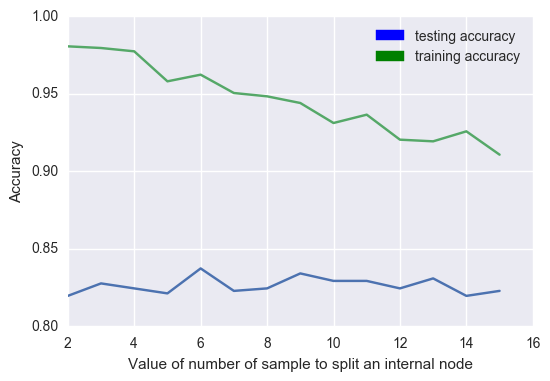

In [31]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(split_range, scores_test, label='training accuracy')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Testing Accuracy')

plt.plot(split_range, scores_train, label='testing error')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Accuracy')

blue = mpatches.Patch(color='blue', label='testing accuracy')
green = mpatches.Patch(color='green', label='training accuracy')
plt.legend(handles=[blue, green])

Indeed we can see that the training accuracy is decreasing with the simplification of the model while the testing accuracy is staying roughly the same (taking the variance into account). In other words the model is overfitting to the training data when we use a small value for this parameter. To be precise, as the testing accuracy doesn't seems to be impacted strongly by the parameter change, the overfitting issue is not really important. True overfitting is when the training accuracy augment while the testing accuracy decrease, which means our model will not generalize well.

Now we will test the n_estimator parameter which represent the number of trees in the forest. This parameter is directly related to the complexity the of the model. Bigger estimator values means more trees which means more complex model.

In [32]:
#Hyperparameter estimator

estimator_range = list(range(5,35))
scores_test = []
scores_train = []
for number in estimator_range:
    randomforest = RandomForestClassifier(n_estimators=number)
    randomforest.fit(features_train, labels_train)
    labels_pred_test = randomforest.predict(features_test) #testing prediction
    labels_pred_train = randomforest.predict(features_train) #training prediction
    
    scores_test.append(metrics.accuracy_score(labels_test, labels_pred_test)) 
    scores_train.append(metrics.accuracy_score(labels_train, labels_pred_train)) 
    

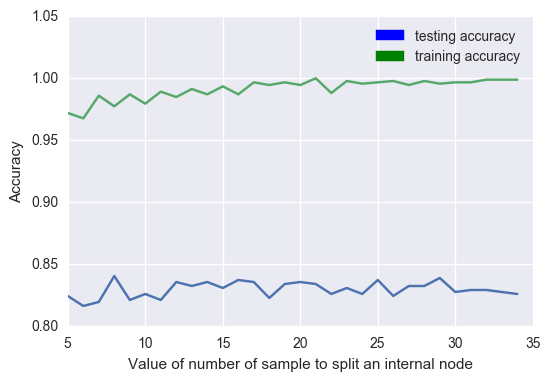

In [33]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(estimator_range, scores_test)
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Testing Accuracy')

plt.plot(estimator_range, scores_train)
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Accuracy')


blue = mpatches.Patch(color='blue', label='testing accuracy')
green = mpatches.Patch(color='green', label='training accuracy')
plt.legend(handles=[blue, green])

Here the training accuracy increase continuously while the testing accuracy increase slighlty at the beginning and then reach a plateau (taking the variance into account). Thus the model is overfitting to the training data when we use a too large number of trees (a complex model)

# Cross validation to mitigate overfitting and parameters tuning

Now we will perform cross validation to have a reliable testing accuracy. After that we will use cross validation to try to fine tune a parameters for better results.

Here we import the cross validation score function and we run a 10 folds cross validation.

In [34]:
from sklearn.cross_validation import cross_val_score

# 10-fold cross-validation

randomforest = RandomForestClassifier(n_estimators=30)
scores = cross_val_score(randomforest, data_features, labels, cv=10, scoring='accuracy')
print(scores)

[ 0.82692308  0.85806452  0.8516129   0.81290323  0.83225806  0.83870968
  0.82580645  0.84516129  0.8516129   0.84516129]


With this crossvalidation we obtain a test accuracy for each 10 folds. We can observe that each testing accuracy is a little smaller than the training accuracy obtained before.
We take the average of the 10 testing accuracy to have a reliable value for the testing accuracy of the Random Forest model we used.

In [35]:
scores.mean()

0.83882133995037234

The average testing accuracy is 85% which is not bad but will often make mistake when trying to predict the color of the skin of a player.

We will try to improve the scores by playing with the hyperparameters of the RandomForest model. We run a cross validation for different value of the parameters n_estimator and look for improvement in accuracy. We perform a 5 folds cross validation (for computation time reasons)

In [36]:
#We make a 5 folds crossvalidation for each value of the hyperparameter 
#(Not 10 as before for computation time reason)

split_range = list(range(5, 50))
split_scores = []
for number in split_range:
    randomforest = RandomForestClassifier(n_estimators=number)
    scores = cross_val_score(randomforest, data_features, labels, cv=10, scoring='accuracy')
    split_scores.append(scores.mean())
print(split_scores)

[0.82592638544251451, 0.8362365591397849, 0.83172043010752683, 0.83558312655086842, 0.8362365591397849, 0.83559553349875926, 0.83559553349875926, 0.83430107526881725, 0.83172456575682374, 0.840760959470637, 0.83751447477253937, 0.83365177832919757, 0.83688999172870149, 0.84591397849462369, 0.83043010752688173, 0.83752688172043011, 0.83495037220843682, 0.83559553349875948, 0.84011166253101732, 0.84526881720430114, 0.83882547559966913, 0.83495037220843682, 0.83881720430107531, 0.84011166253101732, 0.84075268817204307, 0.84590984284532666, 0.83817617866004956, 0.84332919768403636, 0.84204301075268817, 0.83882133995037211, 0.83817617866004956, 0.84011579818031412, 0.83752688172043011, 0.83881306865177829, 0.84010752688172052, 0.84397849462365593, 0.84011579818031434, 0.84462779156327539, 0.83816790736145586, 0.84075682382134009, 0.83817617866004956, 0.83882133995037234, 0.84010752688172041, 0.84332919768403636, 0.84526881720430114]


We plot the results of the cross validation against the n_estimator value

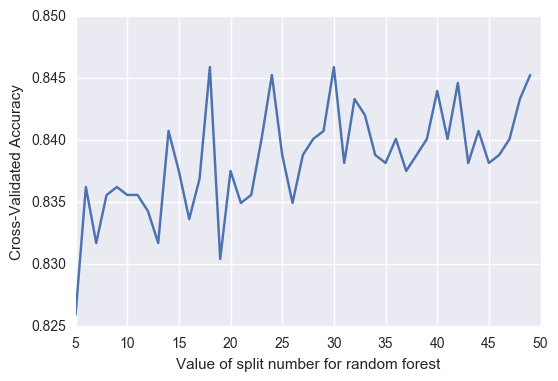

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(split_range, split_scores)
plt.xlabel('Value of split number for random forest')
plt.ylabel('Cross-Validated Accuracy')

We can observe that the accuracy increase before reaching a 'plateau' around value of 30. So using a value of 30 seems enough complexity for the model, but less than 15 could be bad.

We wanted to see if Performing PCA on the features data set increase the prediction accuracy. It doesn't increase the accuracy. It even decrease it a little as can be see below

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

data_features_pca = pca.fit_transform(data_features)

randomforest = RandomForestClassifier(criterion='entropy', n_estimators=35)
scores = cross_val_score(randomforest, data_features_pca, labels, cv=10, scoring='accuracy')
print(scores)

print('Average')
scores.mean()

[ 0.83974359  0.8516129   0.85806452  0.83225806  0.83225806  0.82580645
  0.8         0.84516129  0.84516129  0.83870968]
Average


0.83687758478081054

# Feature Importance

Here we will use RandomForest to output how important each feature is in the classification. We have provided below the names of the column headers and the associated "importance value" it has.

Here we train a random forest model

In [39]:
randomforest = RandomForestClassifier(n_estimators=35)

randomforest.fit(data_features,labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

The feature importances attribute output the importance value of each feature

In [40]:
randomforest.feature_importances_

array([ 0.04763959,  0.02896849,  0.03899084,  0.04060332,  0.03660442,
        0.05560208,  0.05120807,  0.03950218,  0.04420683,  0.05185576,
        0.03904336,  0.01648576,  0.02329653,  0.05273016,  0.05708874,
        0.05740622,  0.09774852,  0.06057477,  0.06272821,  0.083268  ,
        0.01444816])

We sort them and add their corresponding name

In [41]:

Feature_name = data_features.columns # Get Column Headings of our Dataframe

print((sorted(zip(map(lambda value: round(value, 4), randomforest.feature_importances_), Feature_name), 
             reverse=True))) 

[(0.097699999999999995, 'seIAT'), (0.083299999999999999, 'seExp'), (0.062700000000000006, 'nExp'), (0.060600000000000001, 'meanExp'), (0.0574, 'nIAT'), (0.057099999999999998, 'meanIAT'), (0.055599999999999997, 'games'), (0.052699999999999997, 'Alpha_3'), (0.051900000000000002, 'goals'), (0.051200000000000002, 'victories'), (0.047600000000000003, 'club'), (0.044200000000000003, 'defeats'), (0.040599999999999997, 'weight'), (0.0395, 'ties'), (0.039, 'yellowCards'), (0.039, 'height'), (0.036600000000000001, 'position'), (0.029000000000000001, 'leagueCountry'), (0.023300000000000001, 'redCards'), (0.016500000000000001, 'yellowReds'), (0.0144, 'yellowRed')]


For more readability we make a plot of the importance of the parameters in the model. 

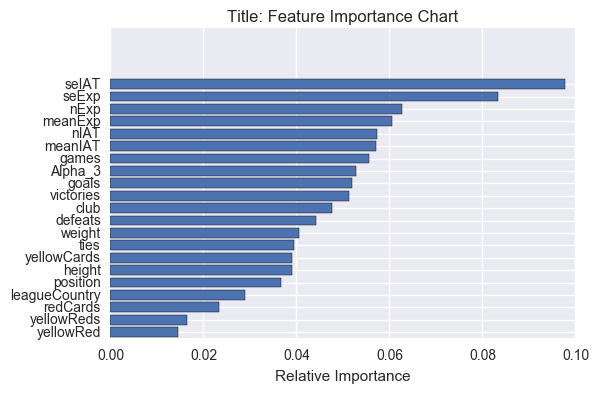

In [42]:
importances = randomforest.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(Feature_name)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, Feature_name[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Title: Feature Importance Chart")
plt.show()

From this plot, we can see that the important feature for the classification of the skin color of the player are the ones related to the IAT and Exp. This make sense as these features are the more prone to uncover a racial discrimination in the data.

Now we will try to obtain different features importance attributes by playing with the data set. Mainly we will drop certain features and see the impact on the features importances

In [43]:
data_new = data_features.copy()
labels_new = labels.copy()
data_new.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,yellowRed
0,29,3,172.0,67.0,7,364,226,57,81,32,...,1,3,30,0.330002,2574735.0,0.000231,0.330002,2655936.0,0.001431,1.0
1,10,3,183.0,73.0,2,294,145,62,87,60,...,0,0,30,0.329110,2565503.0,0.000233,0.329110,2647455.0,0.001179,0.0
2,35,3,171.0,69.0,2,178,53,43,82,39,...,1,0,30,0.366673,87911.0,0.000358,0.366673,92973.0,0.001335,1.0
3,9,3,182.0,78.0,2,322,125,82,115,105,...,3,4,30,0.340878,305901.0,0.000437,0.340878,321422.0,0.002612,3.0
4,66,3,190.0,88.0,5,44,22,6,16,0,...,0,1,30,0.348044,105304.0,0.000459,0.348044,110781.0,0.002894,0.0


We drop certain features 

In [44]:
data_drop = data_new.drop(['nIAT','seIAT','meanIAT','seExp','meanExp','nExp',], axis=1)

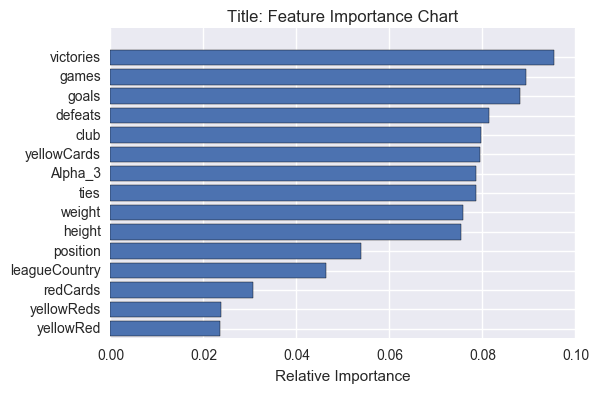

In [45]:
randomforest = RandomForestClassifier(n_estimators=35)

randomforest.fit(data_drop,labels_new)


importances = randomforest.feature_importances_
Feature_name = data_drop.columns # Get Column Headings of our Dataframe
sorted_idx = np.argsort(importances)

padding = np.arange(len(Feature_name)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, Feature_name[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Title: Feature Importance Chart")
plt.show()


We can see that the order of the remainings features is not the same as before. But there is not a significative difference in the value of each features importances.

# Bonus

In this part we will plot the learning curve or our model for 2 differents set of parameters. The goal is to find a set that lead to high bias and another which doesn't.

In theorie, a high bias should arive for a model that is relatively simple. Thus it will not have a strong variance but will always make a large approximation error which is the bias. A model with small bias should be more complex. On the other hand it will probably have a larger variance. In resume a high bias model will be underfitting while a high variance model will be overfitting.

Here we import the learing curve modul and we split data for training and testing set

In [46]:
#split data_features and data_labels into training and testing sets
from sklearn.learning_curve import learning_curve
features_train, features_test, labels_train,labels_test = train_test_split(data_features,
                                                                           labels, test_size=0.4,
                                                                           random_state=4)



/Users/thomasvetterli/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Here we initialize and random forest classifier with parameter that should make the model complex (prone to overfitting) in order to have a large variance and a small bias. We set a high n estimator, a small min sample leaf and a small min samples split. We let the max leaf nodes unlimited, the max depth unlimited and the maxi features unlimited.

In [47]:
BestRankValidationScore=RandomForestClassifier(n_estimators=35, min_samples_leaf= 1,
                                               min_samples_split=1, max_leaf_nodes=None,
                                               max_features=None, max_depth=None,
                                               bootstrap= False)
train_best_sizes, train_best_scores, valid_best_scores = learning_curve(BestRankValidationScore,
                                                                        features_train,
                                                                        labels_train,
                                                                        train_sizes=np.linspace(0.1, 1.0, 15),
                                                                        cv=20)
           

Here we plot the results in the form of a learing curve

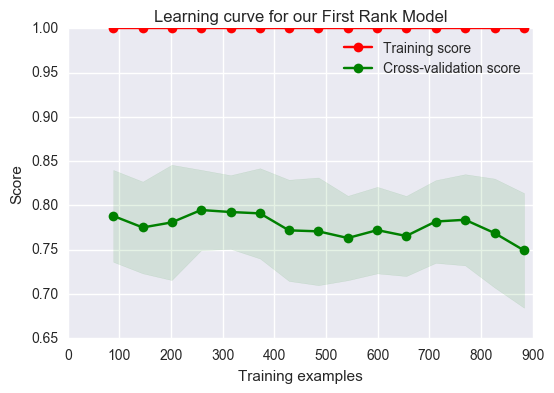

In [48]:
plt.figure()
plt.title("Learning curve for our First Rank Model")

plt.xlabel("Training examples")
plt.ylabel("Score")

train_best_scores_mean = np.mean(train_best_scores, axis=1)
train_best_scores_std = np.std(train_best_scores, axis=1)
valid_best_scores_mean = np.mean(valid_best_scores, axis=1)
valid_best_scores_std = np.std(valid_best_scores, axis=1)
#plt.grid()
plt.fill_between(train_best_sizes, train_best_scores_mean - train_best_scores_std,
                train_best_scores_mean + train_best_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_best_sizes, valid_best_scores_mean - valid_best_scores_std,
                     valid_best_scores_mean + valid_best_scores_std, alpha=0.1, color="g")
plt.plot(train_best_sizes, train_best_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_best_sizes, valid_best_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

plt.show()

We can observe that the training score is always 1.0, so we are actually overfitting. The cross validation score doesn't show a show a clear sign of high bias which would be represented as a bad score for small training sample value. We can also notice a high variance as expected. 

Now we do the exat same thing but for a model that should be simple and thus should have a high bias and less variance. We put the max feature parameter to 2 and max leaf nodes to 14. We also let the standard n estimator value to 10.

In [49]:
ForestClassifierWithBias = RandomForestClassifier(min_samples_leaf= 1,
                                                  min_samples_split= 1, max_leaf_nodes=14,
                                                  max_features= 2, max_depth=None,
                                                  bootstrap= False, criterion = 'entropy')

train_sizes, train_scores, valid_scores = learning_curve(
ForestClassifierWithBias, features_train, labels_train, train_sizes=np.linspace(0.1, 1.0, 30), cv=20)

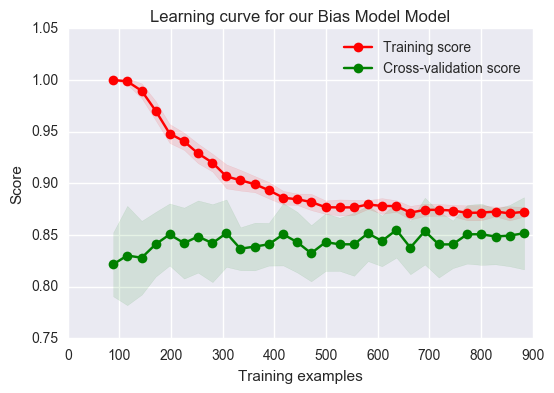

In [50]:
fig = plt.figure()
plt.title("Learning curve for our Bias Model Model")
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
#plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

plt.show()

Now we can observe two things. First, the training score is decreasing with the number of samples used. This is due to the simplification of the model and is expected. The model is simple and every training examples increase the chance of having error. Second, we can see a slight increase in the cross validation score. This increase is due to the bias. Also the variance is lower than in the other case as expected.

# Clustering
For the second part of the exercise we will try clustering the cleaned data.
We begin by extracting the of the raters and doing a mapping for the finding of different cluster representing different skin color.

We begin by extracting the of the raters and doing a mapping for the finding of different cluster representing different skin color.

In [51]:
playerCluster = pd.read_csv('Data/playerData.csv')

In [52]:
#Removing the mean rating column and storing it into a new dataframe
playersNorating = playerCluster.drop('meanRating',axis=1)

#We will define the function to transform the ratings.

def transform_rating(series):
    if series < 0.4:
        return 0
    else:
        return 1
    
labels = playerCluster['meanRating'].apply(transform_rating)

In [53]:
#We still have one NA value that we will remove
playersNorating.dropna(inplace=True)

Now we will iteratively add features and do the clustering, and compute the silhouette score.

<div align="justify">
Furthermore to find if the players have been classified in two groups corresponding to their skin type we will use metrics.accuracy_score. We will have clusters corresponding to skin if the score is very low or very high because we don't know for which skin type the 0 and 1 corresponds to. If they are opposed to what we used then a 0.1 accuracy score would mean that 90% of players are in the right cluster which is also good. </div>

In [62]:
silScore = []
accuracy = []

for i in range(2,playerCluster.shape[1]):
    cluster = KMeans(n_clusters=2,random_state=0).fit(playersNorating.values[:,0:i])
    sil = metrics.silhouette_score(playersNorating.values,cluster.labels_)
    silScore.append(sil)
    accuracy.append(metrics.accuracy_score(labels,cluster.labels_))
    if metrics.accuracy_score(labels,cluster.labels_) > 0.7:
        print(i)

20
21
22


And we take a look at the different silouhette scores. For a recall a score of 1 means that the clusters are well separated, a score of -1 means that they are not well separated.

Maximum accuracy : 0.716312056738


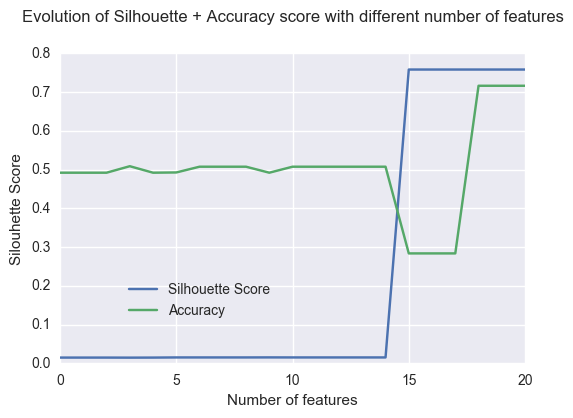

In [55]:
plt.plot(silScore,label='Silhouette Score')
plt.plot(accuracy,label='Accuracy')
plt.title('Evolution of Silhouette + Accuracy score with different number of features',y=1.08)
plt.xlabel('Number of features')
plt.ylabel('Silouhette Score')
plt.legend(loc=9, bbox_to_anchor=(0.3,0.3))
print('Maximum accuracy :', max(accuracy))

<div align="justify">We can clearly see that we get the best silhouette score by using all of the features. At the same time we can see that at one point, using more than 17 features, we start having an accuracy that is very good, so we can assume that the two clusters start representing players of different colors.

We also think that the score stays constant for the last features because for example, the "games" variable is a linear combination of "ties", "defeats" and "victories" so adding it does not add information to the model.

We have also no tested for diffe combinations of removing columns, we will try again by looping through the colums and adding one at a time. We will check if we are able to obtain a better accuracy. </div>

In [56]:
otherSilscore = []
otherAcc = []

for i in range (1,playerCluster.shape[1]-1):
    for j in range(i+1,playerCluster.shape[1]):
          cluster = KMeans(n_clusters=2,random_state=0)\
            .fit(playersNorating[playersNorating.columns[i:j]].values)
          sil = metrics.silhouette_score\
          (playersNorating[playersNorating.columns[i:j]].values,cluster.labels_)
          otherSilscore.append(sil)

          otherAcc.append(metrics.accuracy_score(labels,cluster.labels_))

And we take a look again at the silhouette score for different combinations.

Maximum Accuracy : 0.716312056738


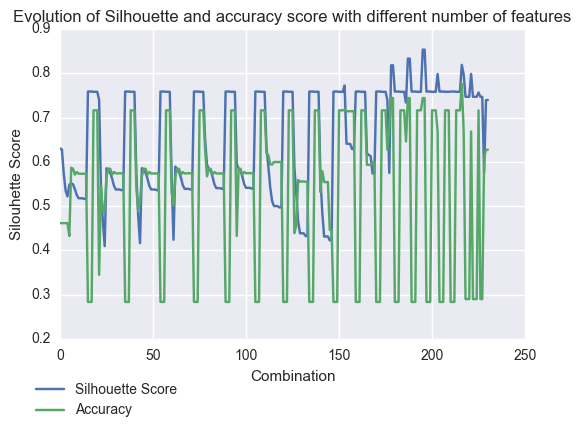

In [57]:
plt.plot(otherSilscore,label='Silhouette Score')
plt.plot(otherAcc,label='Accuracy')
plt.title('Evolution of Silhouette and accuracy score with different number of features')
plt.xlabel('Combination')
plt.ylabel('Silouhette Score')
plt.legend(loc=9, bbox_to_anchor=(0.1,-0.1))
print('Maximum Accuracy :',max(accuracy))

We see that the maximum accuracy corresponds exactly to the one we found previously, that means that we have not found a better combination of features.

We find that we need all of the features to obtain a high accuracy with a high silhouette score, which implies that all features contain information.

#### Removing bias data

This clustering has been done by using all of the features, which include the bias values of the referee, which could influence the clustering.

Let's try to remove the bias data and only cluster the data that represents only the player.

In [58]:
playerOnly = pd.concat([playerCluster[playerCluster.columns[2:14]],
                       playerCluster[['yellowReds','meanRating']]],axis=1)

In [59]:
silScore1 = []
accuracy1 = []

for i in range(2,playerOnly.shape[1]):
    cluster = KMeans(n_clusters=2,random_state=0).fit(playerOnly.values[:,0:i])
    sil = metrics.silhouette_score(playerOnly.values,cluster.labels_)
    silScore1.append(sil)
    accuracy1.append(metrics.accuracy_score(labels,cluster.labels_))

And we plot it again

Maximum accuracy : 0.716312056738


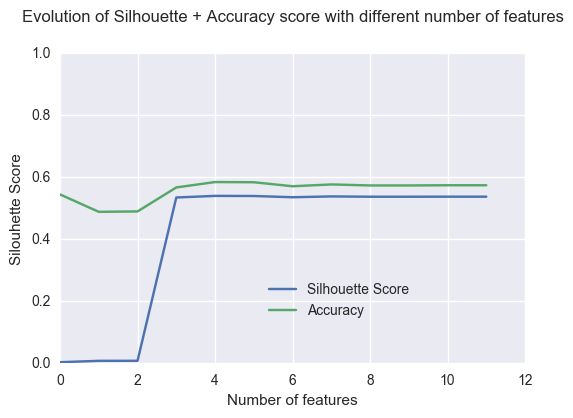

In [60]:
plt.plot(silScore1,label='Silhouette Score')
plt.plot(accuracy1,label='Accuracy')
plt.title('Evolution of Silhouette + Accuracy score with different number of features',y=1.08)
plt.xlabel('Number of features')
plt.ylabel('Silouhette Score')
plt.legend(loc=9, bbox_to_anchor=(0.6,0.3))
plt.ylim([0,1.0])
print('Maximum accuracy :', max(accuracy))

And this time we can see that's it hard to cluster (low silhouette) and that at the sime time the cluster are not containing players regarding skin color


To conclude the clustering, we finf that using the first 19 features of the dataset give us the best classification accuracy and the best silhouette score, therefore we can assume that it's the best way that features can be used to obtain clusters that contain players of different skin colors. As said before this is due to the fact that we need information about country bias to cluster given the color and also that these features play a strong importance in the classifier.

It is also safe to say that our results depend heavily on the chosen way of data cleaning and a different processing pipeline could lead to different results.